In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math 
import pylab 

from matplotlib.dates import DateFormatter
from glob import glob
from os import path
from collections import defaultdict

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

In [2]:
# READ DATA: Blade landings 

blade_landings= pd.read_csv('blade_landing_helihoist_sbitroot.txt')

# make epoch index of dataframe and convert epoch into readable dates
blade_landings.epoch_land= blade_landings.epoch_land.apply(lambda x: pd.to_datetime(x, unit= 's', utc=True))

# convert blade landings of turbine 8 into readable dates
blade_landing1= pd.to_datetime(1.571127e+09	, unit='s', utc=True)
blade_landing2= pd.to_datetime(1.571154e+09, unit='s', utc=True)
blade_landing3= pd.to_datetime(1.571188e+09, unit='s', utc=True)

landings = (blade_landing1, blade_landing2, blade_landing3)

In [3]:
# Read csv files of GPS Data: turbine 8

# sbitroot
gps_sbitroot_tb8= pd.read_csv('GPS/turbine-08_sbitroot_tom_gps.csv')
gps_sbitroot_tb8.epoch= pd.to_datetime(gps_sbitroot_tb8.epoch, unit= 's', utc=True)
gps_sbitroot_tb8.set_index('epoch', inplace=True)

# sbittip
gps_sbittip_tb8= pd.read_csv('GPS/turbine-08_sbittip_tom_gps.csv')
gps_sbittip_tb8.epoch= pd.to_datetime(gps_sbittip_tb8.epoch, unit= 's', utc=True)
gps_sbittip_tb8.set_index('epoch', inplace=True)

# helihoist
gps_helih_tb8= pd.read_csv('GPS/turbine-08_helihoist-1_tom_gps.csv')
gps_helih_tb8.epoch= pd.to_datetime(gps_helih_tb8.epoch, unit= 's', utc=True)
gps_helih_tb8.set_index('epoch', inplace=True)

In [4]:
# Find blade installation period in data

hub_height = 90 # hub height = 90m

# smoothing the time series: cut the outliers and find the 20min mean value
hh, sr, st = (gps_helih_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbitroot_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbittip_tb8.altitude.resample('1s').mean().rolling('20min').mean())

hh_sbi = hh[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
sr_sbi = sr[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
st_sbi = st[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]

# determine start and end period of single blade installations
inst_period = sr_sbi[sr_sbi.index.to_series().diff() > pd.to_timedelta(60, unit='s')].index.to_list()
inst_period.insert(0, sr_sbi.index[0])
inst_period.insert(len(inst_period), sr_sbi.index[-1])
sbi_indices = list()

for i in range(len(inst_period) - 1):
    sbi_indices.append((inst_period[i], hh_sbi[inst_period[i]:inst_period[i+1]].index[-2]))

In [5]:
# concatenate csv data of helihoist 

path_hh = 'tb08/Helihoist'
hh_files = glob(path_hh + "/*.csv")

hh_data_tb8 = []

for filename in hh_files:
    hh_df = pd.read_csv(filename, index_col=None, header=0)
    hh_data_tb8.append(hh_df)

hh_frame = pd.concat(hh_data_tb8, axis=0, ignore_index=True)

hh_frame.epoch= pd.to_datetime(hh_frame.epoch, unit= 's', utc=True)
hh_frame.set_index('epoch', inplace=True)
hh_frame = hh_frame.sort_index()

# concatenate csv data of sbitroot

path_sbitroot = 'tb08/sbitroot'
sbitroot_files = glob(path_sbitroot + "/*.csv")

sbitroot_data_tb8 = []

for filename in sbitroot_files:
    sbitroot_df = pd.read_csv(filename, index_col=None, header=0)
    sbitroot_data_tb8.append(sbitroot_df)

sbitroot_frame = pd.concat(sbitroot_data_tb8, axis=0, ignore_index=True)

sbitroot_frame.epoch= pd.to_datetime(sbitroot_frame.epoch, unit= 's', utc=True)
sbitroot_frame.set_index('epoch', inplace=True)
sbitroot_frame = sbitroot_frame.sort_index()

# concatenate csv data of sbittip

#path_sbittip = r'/Volumes/MASTERTHESE/MasterThese/turines/tb8/Blade_Landings/sbittip'
#sbittip_files = glob(path_sbittip + "/*.csv")

#sbittip_data_tb8 = []

#for filename in sbittip_files:
    #sbittip_df = pd.read_csv(filename, index_col=None, header=0)
    #sbittip_data_tb8.append(sbittip_df)

#sbittip_frame = pd.concat(sbittip_data_tb8, axis=0, ignore_index=True)

#sbittip_frame.epoch= pd.to_datetime(sbittip_frame.epoch, unit= 's', utc=True)
#sbittip_frame.set_index('epoch', inplace=True)
#sbittip_frame = sbittip_frame.sort_index()

In [6]:
# concatenate csv lidar data and convert wind data into UTC
wind_data= pd.read_pickle('environmental_data_all/lidar/turbine_08_LIDAR.pickle')
wind_data= wind_data.resample('1s').ffill()
wind_data.index= wind_data.index.tz_convert('UTC')
# WIND DATENSATZ hört um 00:00 auf, deswegen fehlen Daten! 
#wind_data = pd.read_csv('/Users/lenastroer/Python_Lokal/MasterThese/wind_data_resampled1s_UTC.csv')
#wind_data.set_index('datetime', inplace=True)

In [31]:
# concatenate csv lidar data and convert wind data into UTC
wave_data= pd.read_pickle('environmental_data_all/waves/turbine_08_Waves.pickle')
wave_data= wave_data.resample('1s').ffill()
wave_data.index= wave_data.index.tz_convert('UTC')
# WIND DATENSATZ hört um 00:00 auf, deswegen fehlen Daten! 
#wind_data = pd.read_csv('/Users/lenastroer/Python_Lokal/MasterThese/wind_data_resampled1s_UTC.csv')
#wind_data.set_index('datetime', inplace=True)

# IMPACTS

In [8]:
# Filter out outliers from acceleration measurement

# SBIT root 
median_x = sbitroot_frame.loc[sbitroot_frame['acc_x']<10, 'acc_x'].median()
median_z = sbitroot_frame.loc[sbitroot_frame['acc_z']<10, 'acc_z'].median()

sbitroot_frame['acc_x'] = np.where(sbitroot_frame["acc_x"] >10, median_x,sbitroot_frame['acc_x'])
sbitroot_frame['acc_x'] = np.where(sbitroot_frame["acc_x"] < -10 , median_x,sbitroot_frame['acc_x'])

sbitroot_frame['acc_z'] = np.where(sbitroot_frame["acc_z"] >10, median_z,sbitroot_frame['acc_z'])
sbitroot_frame['acc_z'] = np.where(sbitroot_frame["acc_z"] < -10 , median_z,sbitroot_frame['acc_z'])


In [9]:
print(sbi_indices[0][1])

2019-10-14 15:10:43+00:00


In [10]:
# Find independent oscillation periods

acc_threshold_x = 0.5 #acceleration threshold (m/s^2)
acc_threshold_z = 0.5
acc_threshold_y = 0.3

limit = pd.to_timedelta(60, unit='s') #time limit to avoid correlation
min_impact_time = pd.to_timedelta(10, unit='s') # minimum time of impact event, erasing measurment errors

sbitroot_installation = pd.DataFrame()
hh_installation= pd.DataFrame()
#wind_installation= pd.DataFrame()

# determine the installation times (blade at hub height) in the acceleration data 

for start, end in sbi_indices:
    sbitroot_installation = sbitroot_installation.append(sbitroot_frame[start:end])
    hh_installation = hh_installation.append(hh_frame[start:end])
#print(wind_installation)

## X Direction

In [11]:
# find start values of impact event

sbitroot_ind = sbitroot_installation.acc_x[(abs(sbitroot_installation.acc_x) > acc_threshold_x) & (abs(sbitroot_installation.acc_y) > acc_threshold_y)]

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_startImpact = sbitroot_ind[sbitroot_ind.index.to_series().diff() > limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the start of the first impact event
deltaT_startImpact.insert(0, sbitroot_ind.index[0])

#print(f'deltaT start impact: {deltaT_startImpact}')

In [12]:
# find end values of impact event

sbitroot_ind_inverse = sbitroot_ind.sort_index(ascending=False)

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_endImpact = sbitroot_ind_inverse[sbitroot_ind_inverse.index.to_series().diff() < -limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the end of the last impact event
deltaT_endImpact.insert(0, sbitroot_ind_inverse.index[0])
deltaT_endImpact.sort(reverse=False)


#print(f'deltaT end impact: {deltaT_endImpact}')

In [13]:
impact_times_x = list()

for i in range(len(deltaT_endImpact) ): 
    if (deltaT_endImpact[i]- deltaT_startImpact[i]) > min_impact_time :
        # filter out measurement errors
        impact_times_x.append((deltaT_startImpact[i], deltaT_endImpact[i]))

#print(impact_times)
n_impacts_x = len(impact_times_x)

## Z Direction

In [14]:
# find start values of impact event

sbitroot_ind = sbitroot_installation.acc_z[(abs(sbitroot_installation.acc_z) > acc_threshold_z)& (abs(sbitroot_installation.acc_y) > acc_threshold_y)]

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_startImpact = sbitroot_ind[sbitroot_ind.index.to_series().diff() > limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the start of the first impact event
deltaT_startImpact.insert(0, sbitroot_ind.index[0])

#print(f'deltaT start impact: {deltaT_startImpact}')

In [15]:
# find end values of impact event

sbitroot_ind_inverse = sbitroot_ind.sort_index(ascending=False)

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_endImpact = sbitroot_ind_inverse[sbitroot_ind_inverse.index.to_series().diff() < -limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the end of the last impact event
deltaT_endImpact.insert(0, sbitroot_ind_inverse.index[0])
deltaT_endImpact.sort(reverse=False)


#print(f'deltaT end impact: {deltaT_endImpact}')

In [16]:
impact_times_z = list()

for i in range(len(deltaT_endImpact) ): 
    if (deltaT_endImpact[i]- deltaT_startImpact[i]) > min_impact_time :
        # filter out measurement errors
        impact_times_z.append((deltaT_startImpact[i], deltaT_endImpact[i]))

# INDEPENDENT deflection

In [17]:
# Impact times combined

impact_times = impact_times_z + impact_times_x
impact_times.sort()
#print(impact_times)

In [18]:
inst_stages= []
for start, end in sbi_indices:
    inst_stages.append (sbitroot_frame[start:end].acc_x)

In [19]:
# Find start values of sbi and impacts

sbi_indices_start = [i[0] for i in sbi_indices]
sbi_indices_end = [i[1] for i in sbi_indices]
impact_times_start = [i[0] for i in impact_times]

# Remove all impact starts after the end of the environmental data set, so that the deflection data set is of 
#equal length to wind dataset. 

impact_times_start= [x for x in impact_times_start if x < wind_data.index[-1]]


# if the last first impact of the installation attempt gets cut off due to the shorter environmental data set, 
# then add the last Datetime of environmental data in impacts (treated as impact event)

if impact_times_start[-1]< sbi_indices_start[-1]:
    impact_times_start.append(wind_data.index[-1])

In [39]:
# create a list which contains the wind conditions during installation

wind_installation = []
for j in range(len(sbi_indices)):
    wind_installation.append(wind_data.wind_speed_0[sbi_indices_start[j]:sbi_indices_end[j]])
    
wave_installation = []
for j in range(len(sbi_indices)):
    wave_installation.append(wave_data.Hm0[sbi_indices_start[j]:sbi_indices_end[j]])
#print(indep_wind[3].index)
#print(indep_deflection[3].index)
print(wind_installation)

[datetime
2019-10-14 12:30:18+00:00    1.0
2019-10-14 12:30:19+00:00    1.1
2019-10-14 12:30:20+00:00    1.1
2019-10-14 12:30:21+00:00    1.0
2019-10-14 12:30:22+00:00    1.0
                            ... 
2019-10-14 15:10:39+00:00    6.4
2019-10-14 15:10:40+00:00    6.7
2019-10-14 15:10:41+00:00    6.2
2019-10-14 15:10:42+00:00    6.2
2019-10-14 15:10:43+00:00    6.2
Freq: S, Name: wind_speed_0, Length: 9626, dtype: float64, datetime
2019-10-15 06:32:25+00:00    9.9
2019-10-15 06:32:26+00:00    9.2
2019-10-15 06:32:27+00:00    9.2
2019-10-15 06:32:28+00:00    8.4
2019-10-15 06:32:29+00:00    8.8
                            ... 
2019-10-15 08:26:25+00:00    8.4
2019-10-15 08:26:26+00:00    9.4
2019-10-15 08:26:27+00:00    9.4
2019-10-15 08:26:28+00:00    9.1
2019-10-15 08:26:29+00:00    9.3
Freq: S, Name: wind_speed_0, Length: 6845, dtype: float64, datetime
2019-10-15 12:16:23+00:00    8.4
2019-10-15 12:16:24+00:00    8.4
2019-10-15 12:16:25+00:00    9.1
2019-10-15 12:16:26+00:00    

In [21]:
# identify period from start sbi-period to first impact = INDEPENDENT OSCILLATION
# write first impacts after start of blade installation into list
# to identify independent oscillations, timestamp of impact needs to be bigger than timestamp of sbi-period
# timestamp of impact needs to be the first impact after sbi-period

# indices of first impacts
first_impacts = []
# timestamp of first impacts
first_impacts_start = []
    
for i in range (len(sbi_indices_start)):
    first_impacts.append(next(x for x, val in enumerate(impact_times_start)
                                  if val > sbi_indices_start[i] ))
    
    
for i in range(len(sbi_indices_start)):
    first_impacts_start.append(impact_times_start[first_impacts[i]])

In [22]:
independent_osc = []
for i in range (len(sbi_indices_start)):
        independent_osc.append(sbitroot_installation.acc_z[sbi_indices_start[i]:impact_times_start[first_impacts[i]]])

In [23]:
# create a list which contains the independent oscillations from sbi start until the first impact event

indep_deflection = []
for j in range(len(first_impacts)):
    indep_deflection.append(sbitroot_installation.deflection[sbi_indices_start[j]:impact_times_start[first_impacts[j]]])
    #print(len(indep_deflection[j]))

# INDEPENDENT Environment

In [32]:
# create a list which contains the independent wind conditions
indep_wind = []
for j in range(len(first_impacts)):
    indep_wind.append(wind_data.wind_speed_0[sbi_indices_start[j]:impact_times_start[first_impacts[j]]])
#print(indep_wind[3].index)
#print(indep_deflection[3].index)
indep_wave = []
for j in range(len(first_impacts)):
    indep_wave.append(wave_data.Hm0[sbi_indices_start[j]:impact_times_start[first_impacts[j]]])

<IPython.core.display.Javascript object>


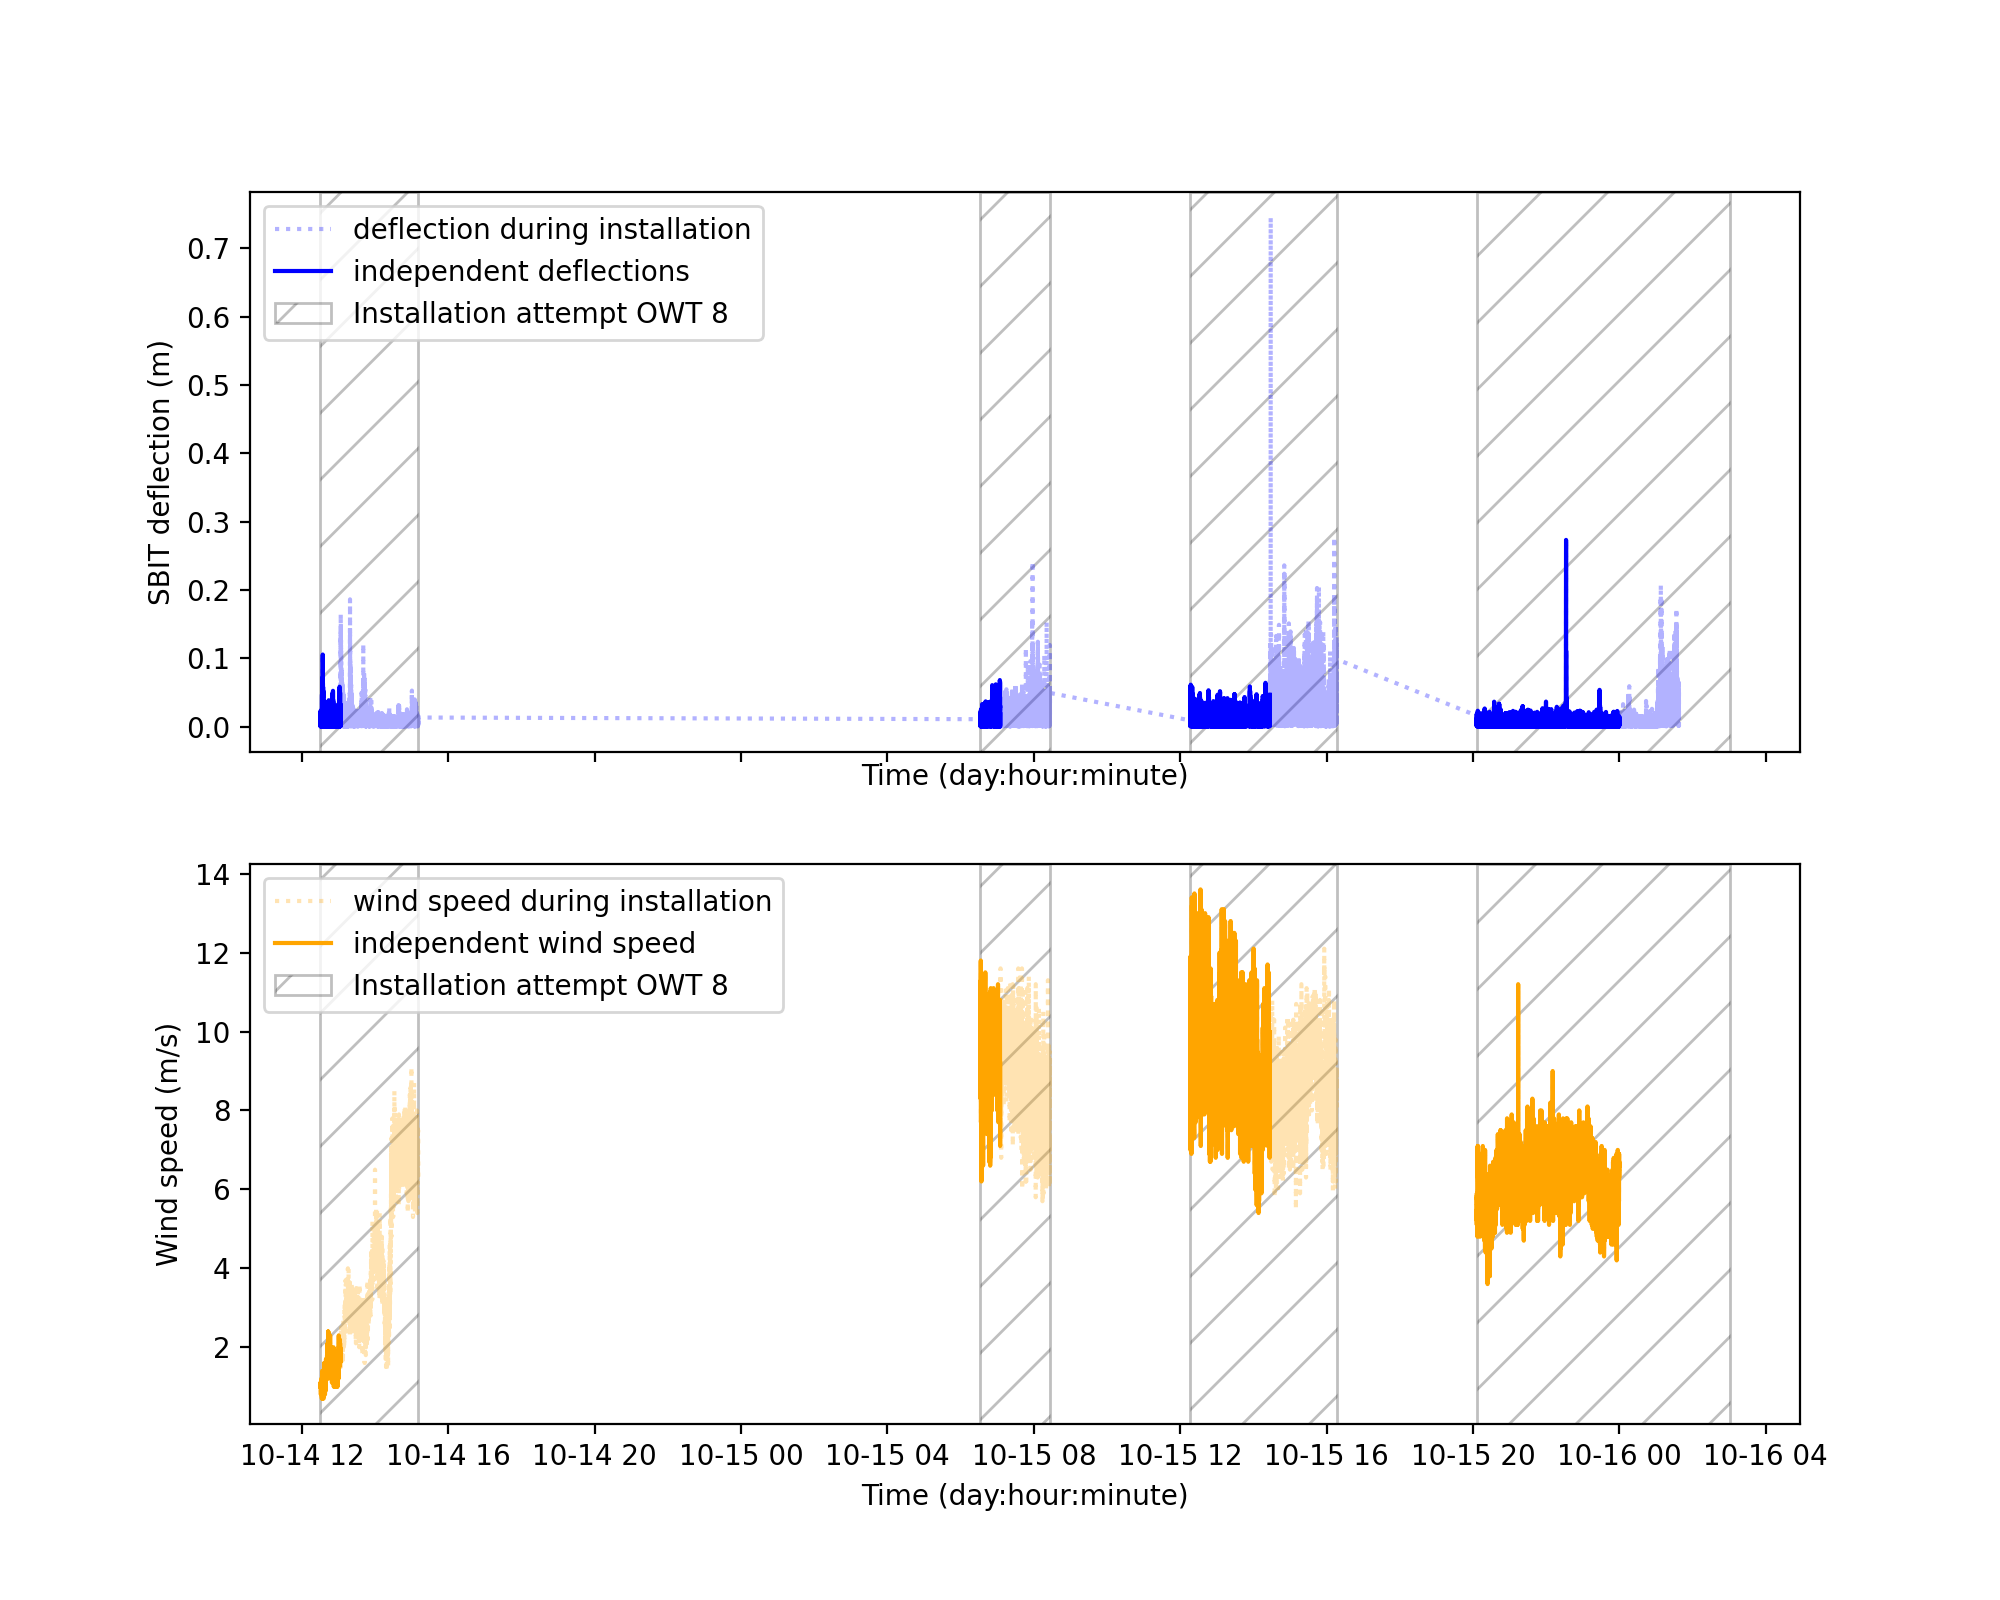

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))

ax1.plot(sbitroot_installation.deflection, color='b', alpha= 0.3, linestyle=':', label='deflection during installation')

ax2.plot(wind_installation[0], color='orange', alpha= 0.3, linestyle=':', label='wind speed during installation') 
ax2.plot(wind_installation[1], color='orange', alpha= 0.3, linestyle=':')
ax2.plot(wind_installation[2], color='orange', alpha= 0.3, linestyle=':')
ax2.plot(wind_installation[3], color='orange', alpha= 0.3, linestyle=':')
    
ax1.plot(sbitroot_installation.deflection[sbi_indices_start[0]:impact_times_start[first_impacts[0]]], color='b', label='independent deflections')
ax1.plot(sbitroot_installation.deflection[sbi_indices_start[1]:impact_times_start[first_impacts[1]]], color='b') 
ax1.plot(sbitroot_installation.deflection[sbi_indices_start[2]:impact_times_start[first_impacts[2]]], color='b') 
ax1.plot(sbitroot_installation.deflection[sbi_indices_start[3]:impact_times_start[first_impacts[3]]], color='b') 
    
ax2.plot(indep_wind[0], color='orange', label='independent wind speed')
ax2.plot(indep_wind[1], color='orange')
ax2.plot(indep_wind[2], color='orange')
ax2.plot(indep_wind[3], color='orange')
  
    
ax1.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax1.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation attempt OWT 8')   
ax1.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax1.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   

ax2.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax2.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation attempt OWT 8')   
ax2.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax2.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')


ax1.set_ylabel('SBIT deflection (m)')
ax2.set_ylabel('Wind speed (m/s)')
ax1.set_xlabel('Time (day:hour:minute)')
ax2.set_xlabel('Time (day:hour:minute)')

ax1.legend()
ax2.legend()

<IPython.core.display.Javascript object>


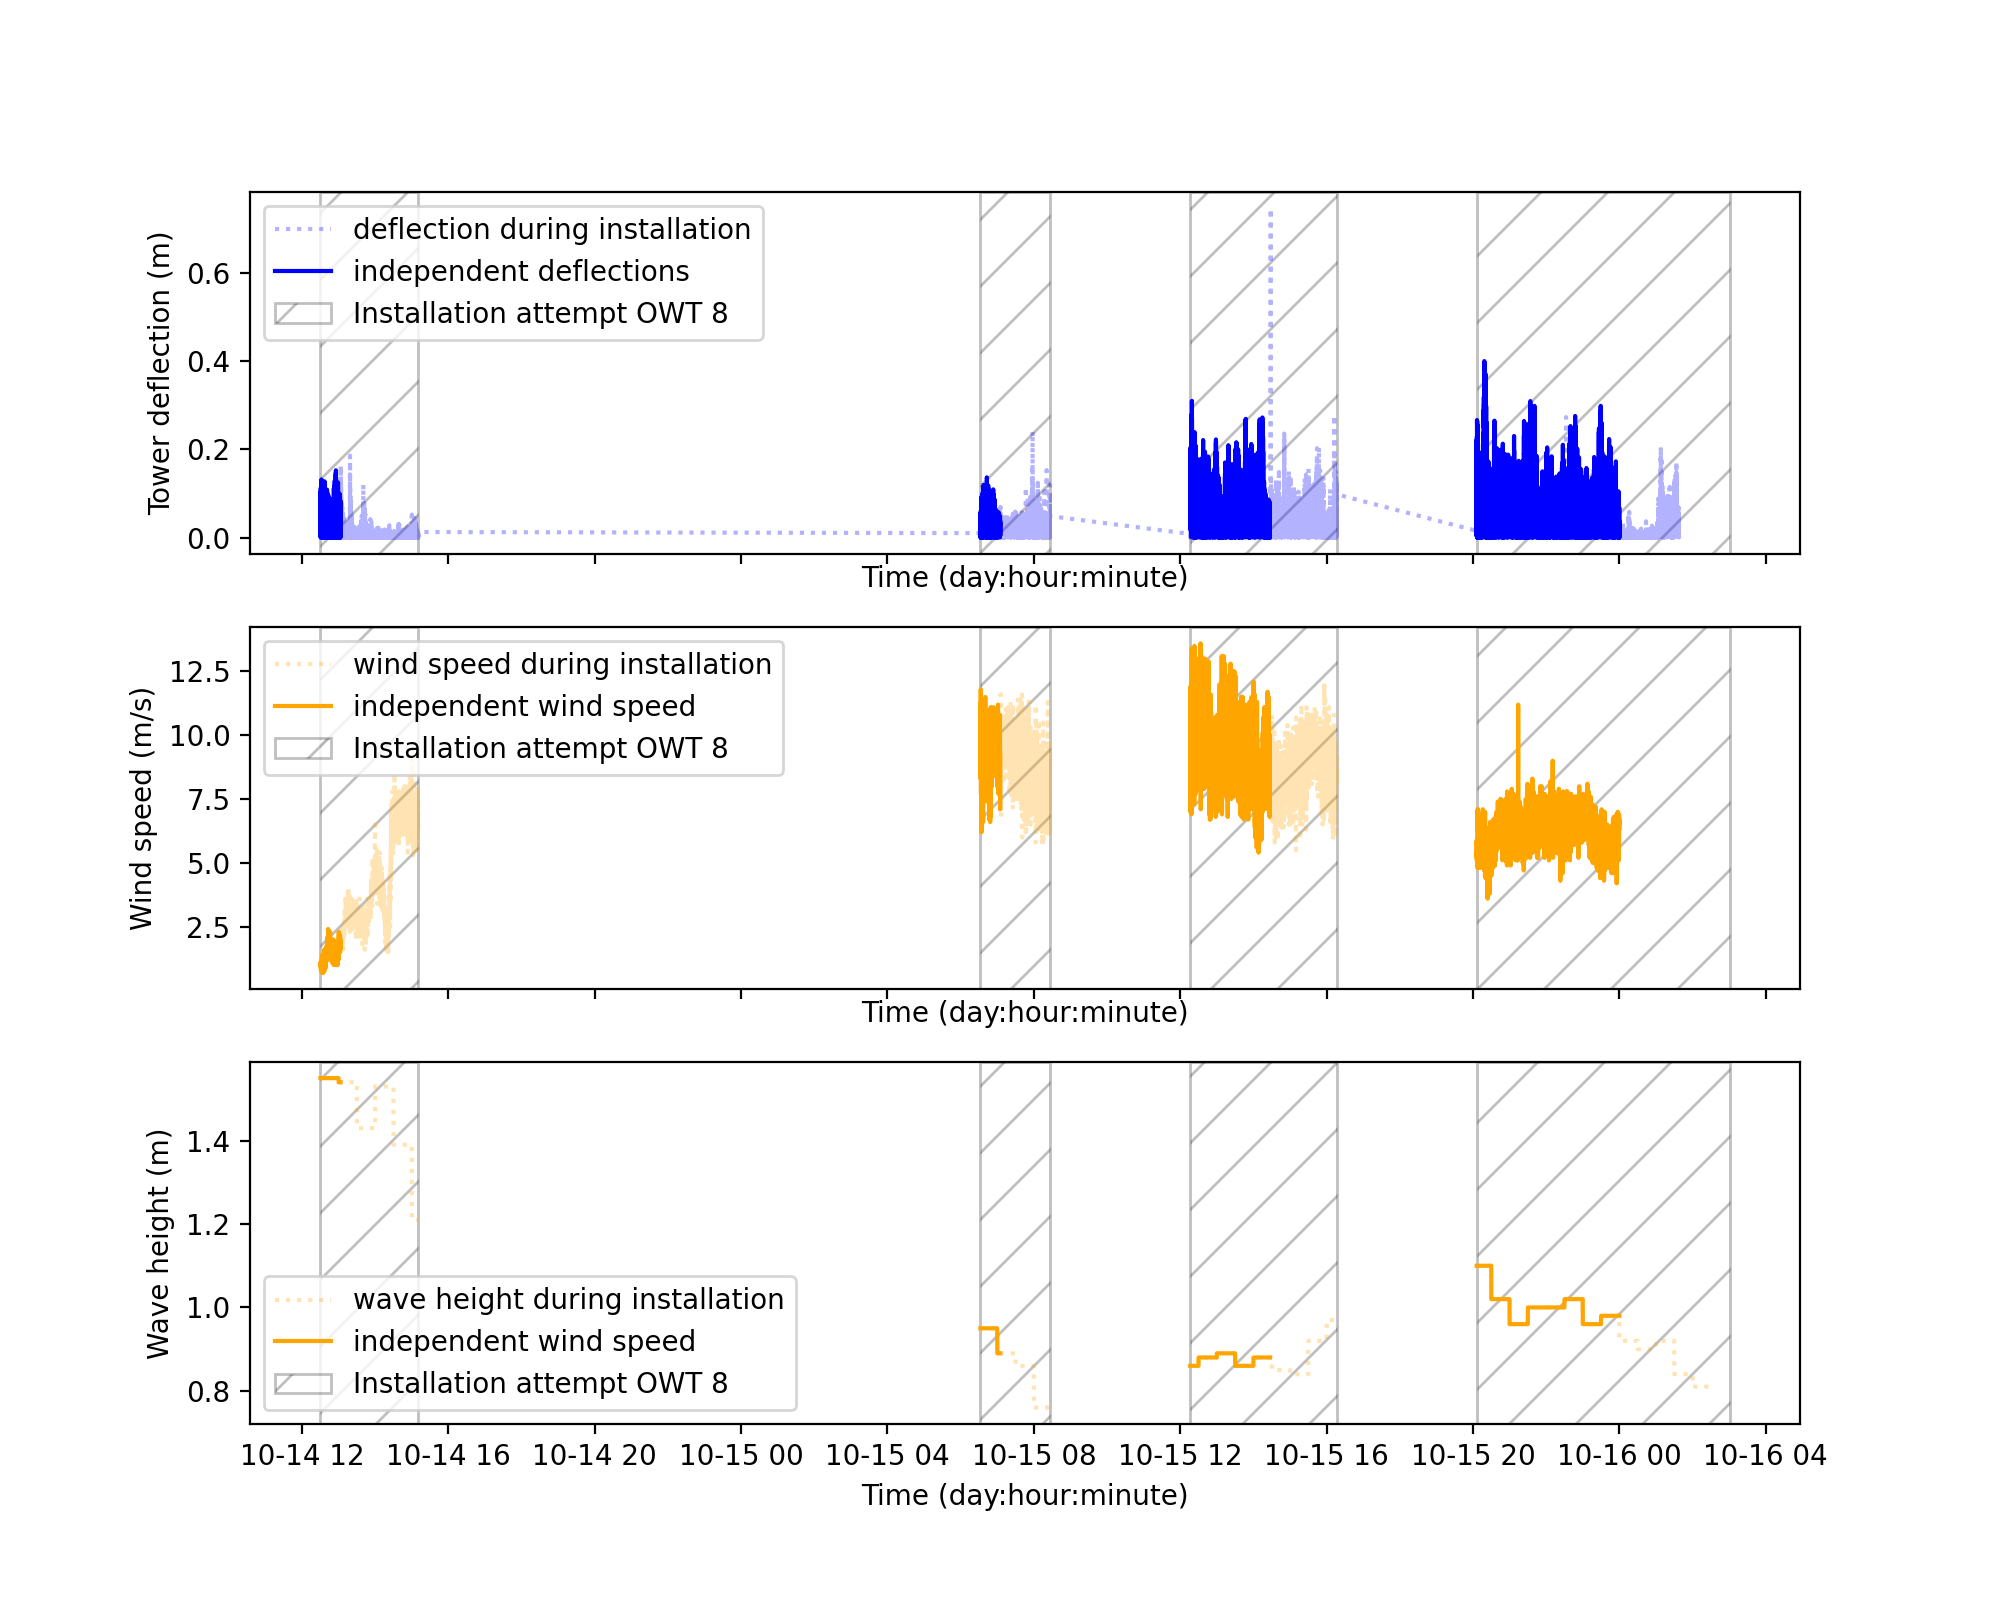

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))

ax1.plot(sbitroot_installation.deflection, color='b', alpha= 0.3, linestyle=':', label='deflection during installation')

ax2.plot(wind_installation[0], color='orange', alpha= 0.3, linestyle=':', label='wind speed during installation') 
ax2.plot(wind_installation[1], color='orange', alpha= 0.3, linestyle=':')
ax2.plot(wind_installation[2], color='orange', alpha= 0.3, linestyle=':')
ax2.plot(wind_installation[3], color='orange', alpha= 0.3, linestyle=':')
    
ax1.plot(hh_installation.deflection[sbi_indices_start[0]:impact_times_start[first_impacts[0]]], color='b', label='independent deflections')
ax1.plot(hh_installation.deflection[sbi_indices_start[1]:impact_times_start[first_impacts[1]]], color='b') 
ax1.plot(hh_installation.deflection[sbi_indices_start[2]:impact_times_start[first_impacts[2]]], color='b') 
ax1.plot(hh_installation.deflection[sbi_indices_start[3]:impact_times_start[first_impacts[3]]], color='b') 
    
ax2.plot(indep_wind[0], color='orange', label='independent wind speed')
ax2.plot(indep_wind[1], color='orange')
ax2.plot(indep_wind[2], color='orange')
ax2.plot(indep_wind[3], color='orange')

    
ax1.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax1.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation attempt OWT 8')   
ax1.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax1.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   

ax2.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax2.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation attempt OWT 8')   
ax2.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax2.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   

ax3.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax3.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation attempt OWT 8')   
ax3.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax3.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   

ax3.plot(wave_installation[0], color='orange', alpha= 0.3, linestyle=':', label='wave height during installation') 
ax3.plot(wave_installation[1], color='orange', alpha= 0.3, linestyle=':')
ax3.plot(wave_installation[2], color='orange', alpha= 0.3, linestyle=':')
ax3.plot(wave_installation[3], color='orange', alpha= 0.3, linestyle=':')

ax3.plot(indep_wave[0], color='orange', label='independent wind speed')
ax3.plot(indep_wave[1], color='orange')
ax3.plot(indep_wave[2], color='orange')
ax3.plot(indep_wave[3], color='orange')

ax1.set_ylabel('Tower deflection (m)')
ax2.set_ylabel('Wind speed (m/s)')
ax1.set_xlabel('Time (day:hour:minute)')
ax2.set_xlabel('Time (day:hour:minute)')
ax3.set_ylabel('Wave height (m)')
ax3.set_xlabel('Time (day:hour:minute)')
ax1.legend()
ax2.legend()
ax3.legend()

<IPython.core.display.Javascript object>


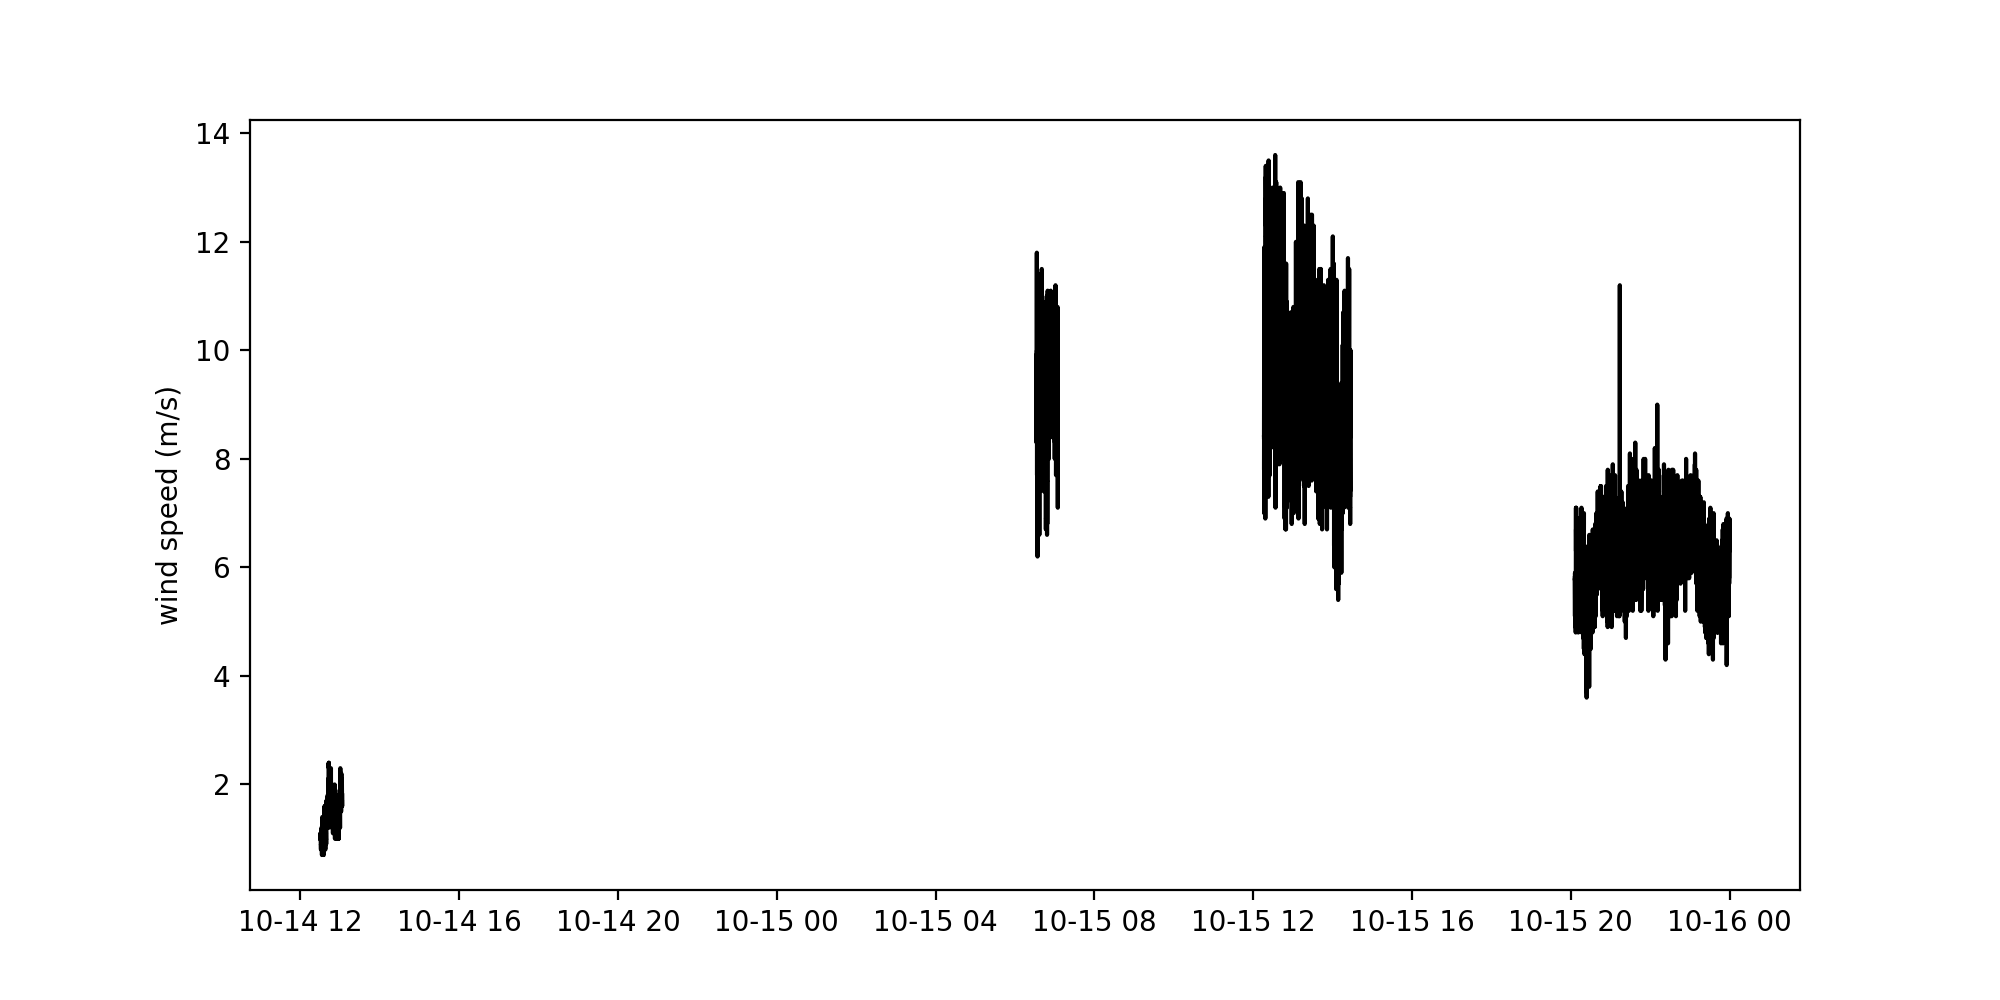

Text(0, 0.5, 'wind speed (m/s)')

In [28]:
fig, (ax1) = plt.subplots( figsize=(10, 5))
ax1.plot()

for i in range(len(first_impacts)):
    ax1.plot(indep_wind[i], color= 'k')   
ax1.set_ylabel('wind speed (m/s)') 

In [29]:
print(sbi_indices_start)
print(first_impacts_start)

[Timestamp('2019-10-14 12:30:18+0000', tz='UTC'), Timestamp('2019-10-15 06:32:25+0000', tz='UTC'), Timestamp('2019-10-15 12:16:23+0000', tz='UTC'), Timestamp('2019-10-15 20:06:10+0000', tz='UTC')]
[Timestamp('2019-10-14 13:03:07.479000092+0000', tz='UTC'), Timestamp('2019-10-15 07:04:47.648999929+0000', tz='UTC'), Timestamp('2019-10-15 14:27:07.305000067+0000', tz='UTC'), Timestamp('2019-10-15 23:59:59+0000', tz='UTC', freq='S')]


# Block Maxima Deflection

In [30]:
# calculate number of chunks for each independent interval 
# number of chunks is the length of the independent interval divided by the time interval
# therfore, the start value minus the end value of the independent interval is the time difference 

time_interval = pd.to_timedelta(60, unit='s')

indep_duration = []
for i in range(len(sbi_indices_start)):
    indep_duration.append(first_impacts_start[i] - sbi_indices_start[i])
    #print(indep_duration[i].total_seconds())

num_chunks = []
for i in range(len(sbi_indices_start)):
    num_chunks.append(indep_duration[i]/time_interval)
print(num_chunks)

[32.824650001533335, 32.37748333215, 130.73841666778333, 233.81666666666666]


In [31]:
# Determine the chunk size in each independent time interval 

chunk_size_deflection = []
for i in range(len(sbi_indices_start)):
    chunk_size_deflection.append(len(indep_deflection[i])/ num_chunks[i])
    chunk_size_deflection[i] = math.floor(chunk_size_deflection[i])
    
chunk_size_deflection = min(chunk_size_deflection) 

In [32]:
def divide_chunks(lst, n):
    #Yield successive n-sized chunks from lst.
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [33]:
# Create list with chunks of independent intervals 
# Independent oscillations are split up into chunks
# indep_blocks[i][j], here i indicates the installation attempt j indicates the blocks in each installation attempt

indep_blocks = []
for i in range(len(sbi_indices_start)):
    indep_blocks.append(list(divide_chunks(indep_deflection[i], chunk_size_deflection)))
    print(len(indep_blocks[i]))

33
33
131
234


In [34]:
# Determine block maxima, blocks that does not contain full 60 sec of data are filtered out. 

block_maxima = []

for i in range(len(sbi_indices_start)):
    for j in range(len(indep_blocks[i])):
        if len(indep_blocks[i][j]) == len(indep_blocks[0][0]): 
            block_maxima.append((indep_blocks[i][j].idxmax(), max(indep_blocks[i][j]) ))
print(len(block_maxima))

427


In [35]:
maxima_values = []
for i in range (len(block_maxima)):
    maxima_values.append(block_maxima[i][1])

In [36]:
indep_timestamps = []

for i in range(len(sbi_indices_start)):
    for j in range(len(indep_blocks[i])):
        indep_timestamps.append(indep_blocks[i][j].index[-1])

<IPython.core.display.Javascript object>


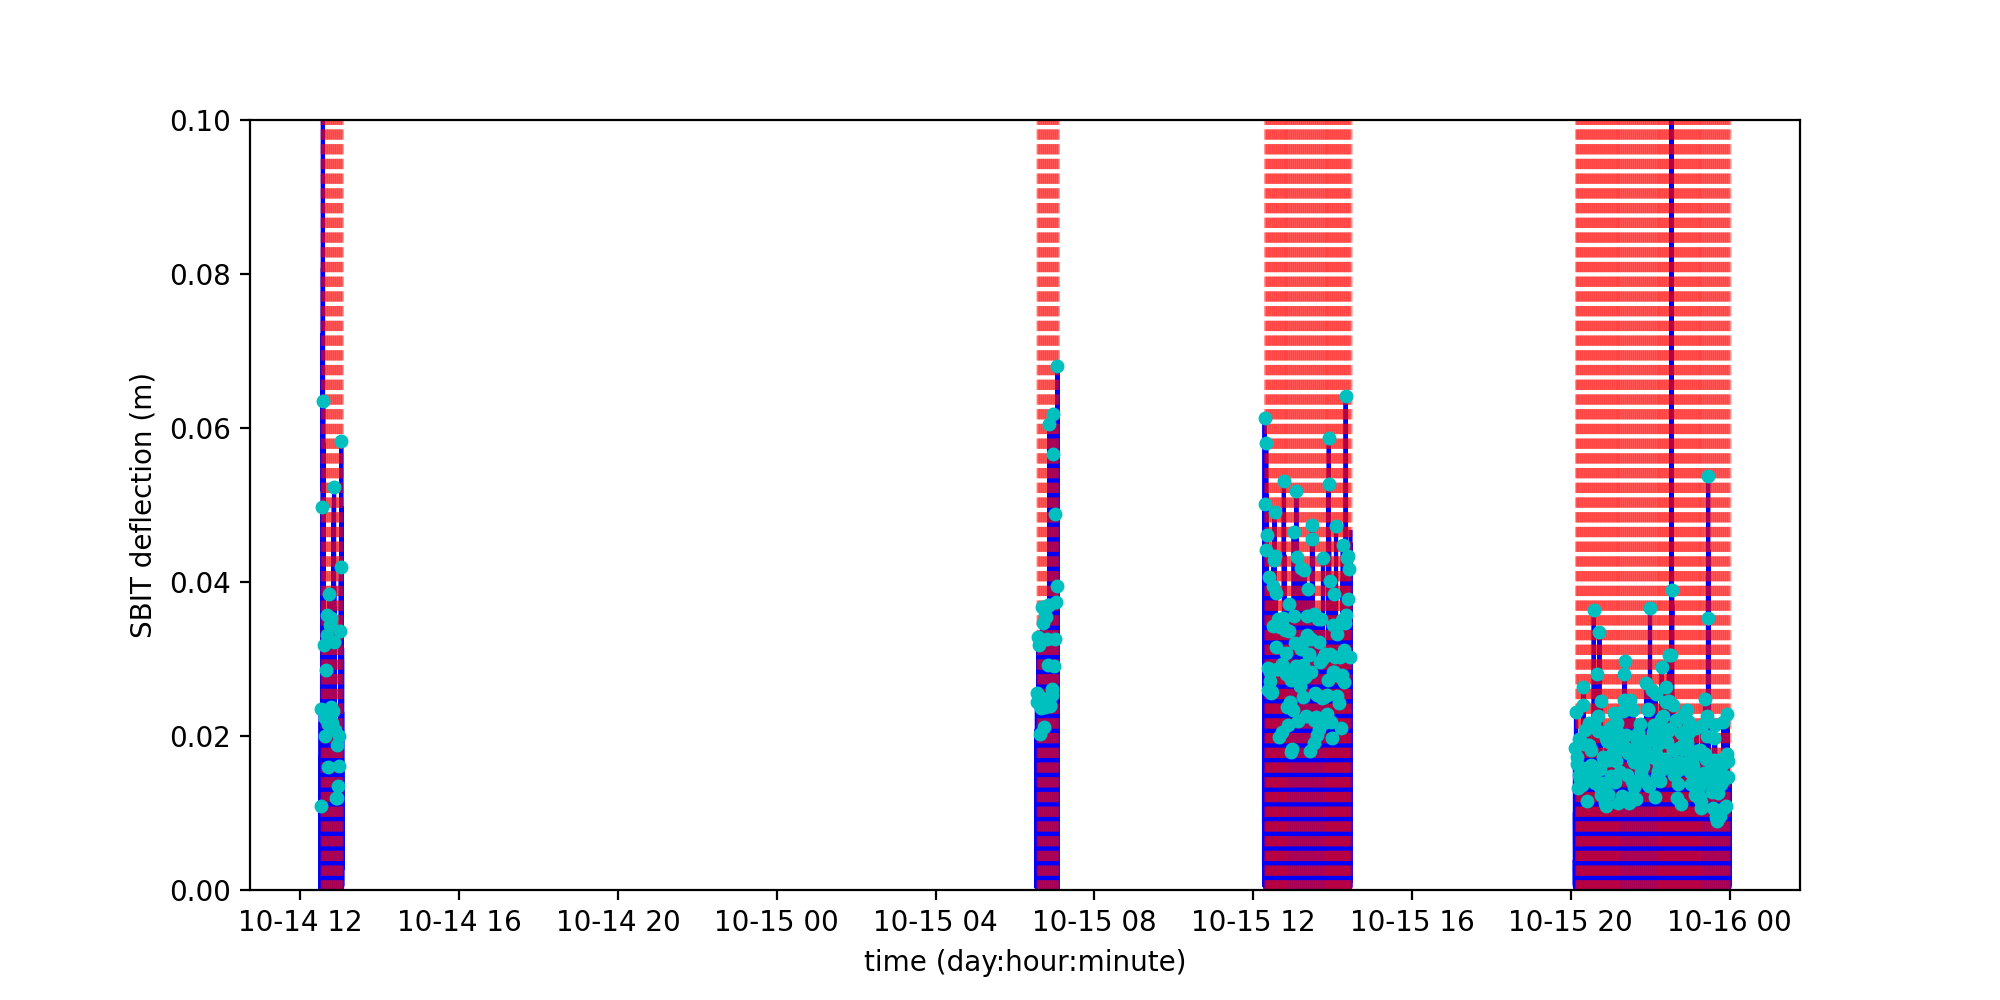

(0.0, 0.1)

In [37]:
plt.figure(figsize=(10,5))

for j in range(len(first_impacts)):
    plt.plot(sbitroot_installation.deflection[sbi_indices_start[j]:impact_times_start[first_impacts[j]]], color='b')
    
for i in range(len(indep_timestamps)):
    plt.axvline(x= indep_timestamps[i], color= 'r',linestyle= '--' , linewidth=1, alpha=0.25)  

for k in range(len(block_maxima)):
    plt.plot(block_maxima[k][0], block_maxima[k][1], color= 'c', marker='o', linestyle='dashed', linewidth=2, markersize=4)


plt.xlabel('time (day:hour:minute)')
plt.ylabel('SBIT deflection (m)') 
plt.ylim(0,0.10)
#plt.axes.set_major_formatter(DateFormatter('%H:%M'))

# Mean block wind speed

In [38]:
# Determine the chunk size in each independent time interval 

chunk_size_wind = []
for i in range(len(sbi_indices_start)):
    chunk_size_wind.append(len(indep_wind[i])/ num_chunks[i])
    chunk_size_wind[i] = math.floor(chunk_size_wind[i])
    #chunk_size_wind[i] = math.ceil(chunk_size_wind[i])
    
chunk_size_wind = min(chunk_size_wind) 

#print(indep_duration)
print(num_chunks)
print(len(indep_wind[3]))
print(chunk_size_wind)

[32.824650001533335, 32.37748333215, 130.73841666778333, 233.81666666666666]
14030
60


In [39]:
# Create list with chunks of independent intervals 
# Independent oscillations are split up into chunks
# indep_blocks[i][j], here i indicates the installation attempt j indicates the blocks in each installation attempt

indep_blocks_wind = []
for i in range(len(sbi_indices_start)):
    indep_blocks_wind.append(list(divide_chunks(indep_wind[i], chunk_size_wind)))
    print(len(indep_blocks_wind[i]))

33
33
131
234


In [40]:
# Determine block maxima, blocks that does not contain full 60 sec of data are filtered out. 

block_mean_wind = []

for i in range(len(sbi_indices_start)):
    for j in range(len(indep_blocks_wind[i])):
        if len(indep_blocks_wind[i][j]) == len(indep_blocks_wind[0][0]): 
            block_mean_wind.append((indep_blocks_wind[i][j].mean() ))
print(len(block_mean_wind))

427


# Response Emulator

## Data

In [ ]:
data_unsorted = {'windspeed':block_mean_wind,'deflection':maxima_values}
data_unsorted = pd.DataFrame(data_unsorted)
data_unsorted["deflection"] = 100 * data_unsorted["deflection"] # convert deflection into cm
data_unsorted.to_csv('data_unsorted.csv')

In [ ]:
block_mean_wind.sort()
maxima_values.sort()

data_sorted = {'windspeed':block_mean_wind,'deflection':maxima_values}
data_sorted = pd.DataFrame(data_sorted)
data_sorted["deflection"] = 100 * data_sorted["deflection"] # convert deflection into cm
data_sorted.to_csv('data_sorted.csv')